### 1) Web Scraping

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
baseurl = 'https://www.dfimoveis.com.br/'

In [3]:
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.63 Safari/537.36'}

In [4]:
r = requests.get('https://www.dfimoveis.com.br/aluguel/df/todos/asa-norte/apartamento')

In [5]:
soup = BeautifulSoup(r.content, 'lxml')

In [6]:
productlist = soup.find_all('li', class_ = 'property-list__item')

In [7]:
def dynamic_portion(soup):
    temp_data = {}
    for item in soup.findAll('h6',class_ ='mb-0 text-normal'):
        item = item.text.split(':')
        if len(item)==2:
            key,val = map(str.strip,item)
            temp_data[key]=val
    return temp_data 

productlinks = []
aps = []
baseurl = 'https://www.dfimoveis.com.br/'
for x in range(1,100):
  r = requests.get(f'https://www.dfimoveis.com.br/aluguel/df/brasilia/apartamento?pagina={x}')
  soup = BeautifulSoup(r.content, 'lxml')
  productlist = soup.find_all('li', class_ = 'property-list__item')
  for item in productlist:
    for link in item.find_all('meta',itemprop = 'url'):
        productlinks.append(baseurl + link['content'])

for link in productlinks:
    r = requests.get(link)
    soup = BeautifulSoup(r.content, 'lxml')
    name = soup.find_all('h1', class_ = 'mb-0 font-weight-600 fs-1-5')[0].text.strip()
    price = soup.find_all('small', class_ = 'display-5 text-warning')[2].text.strip()
    area = soup.find_all('small', class_ = 'display-5 text-warning')[0].text.replace("m²","").strip()
    valueperm2 = soup.find_all('small', class_ = 'display-5 text-warning')[1].text.strip()
    data = {'name':name,
            'link':link,
            'price':price,
            'area':area,
            'valueperm2':valueperm2
            }
    temp_data = dynamic_portion(soup)
    data.update(temp_data)
    print(data)
    aps.append(data)

{'name': 'SQNW 309 Bloco F', 'link': 'https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-noroeste-brasilia-df-sqnw-309-bloco-f-586634', 'price': '9.000', 'area': '150,00', 'valueperm2': '60', 'Quartos': '3', 'Suítes': '3', 'Garagens': '3', 'Condomínio R$': '1.700', 'Cidade': 'BRASÍLIA - NOROESTE', 'IPTU R$': '2.300'}
{'name': 'SQN 407 Bloco P', 'link': 'https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-asa-norte-brasilia-df-sqn-407-bloco-p-581343', 'price': '2.100', 'area': '60,00', 'valueperm2': '35', 'Quartos': '2', 'Condomínio R$': '530', 'Cidade': 'BRASÍLIA - ASA NORTE', 'Área Total': '77,00 m²'}
{'name': 'QMSW 5', 'link': 'https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-sudoeste-brasilia-df-qmsw-5-287793', 'price': '1.300', 'area': '26,00', 'valueperm2': '50', 'Quartos': '1', 'Garagens': '1', 'Condomínio R$': '309', 'Cidade': 'BRASÍLIA - SUDOESTE', 'Andar do Apartamento': '1° Andar', 'Total de Andar do Empreendimento': '4 Andares'}
{'name

In [8]:
import pandas as pd
df = pd.DataFrame(aps)

In [9]:
df.to_csv('../data/data.csv', encoding='utf-8')

### 2) Pré-processamento dos dados

In [1329]:
import pandas as pd
df = pd.read_csv('../data/data.csv',encoding='utf-8')

In [1330]:
df.price.replace('\.','', regex=True,inplace=True)
df.price = df.price.astype(int)

In [1331]:
df.drop(df[df.price > 50000].index, inplace=True)

In [1332]:
df.area = df.area.str.split(',').str[0]

In [1333]:
df.area.replace('\.','', regex=True,inplace=True)
df.area = df.area.astype(int)

In [1334]:
df.drop(df[df.area > 2000].index, inplace=True)
df.drop(df[df.area == 0].index, inplace=True)

In [1335]:
df.area.describe()

count    1893.000000
mean       72.574749
std        64.038517
min         1.000000
25%        30.000000
50%        51.000000
75%        95.000000
max      1100.000000
Name: area, dtype: float64

In [1336]:
df.loc[df['area'] > 1000,'area'] = df['area']/10

In [1337]:
df.loc[df['area'] == 900] 

,Unnamed: 0,name,link,price,area,valueperm2,Quartos,Suítes,Garagens,Condomínio R$,...,Área Total,Andar do Apartamento,Total de Andar do Empreendimento,Nome do Edifício,Posição do Sol,Área Terreno,Posição do Imóvel,Unidades no Andar,Aceita Financiamento,Aceita Permuta
353,353,SQS 211 Bloco I,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-asa-sul-brasilia-df-sqs-211-bloco-i-579804,45000,900,50.0,4.0,4.0,3.0,6.0,...,"900,00 m²",6° Andar,7 Andares,NaN,NaN,NaN,NaN,2.0,NaN,NaN


In [1338]:
df['Condomínio R$'].describe() #vamos ter que preencher os vazios

count    1683.000000
mean      364.225308
std       283.205626
min         0.000000
25%       100.000000
50%       350.000000
75%       550.000000
max       995.000000
Name: Condomínio R$, dtype: float64

In [1339]:
df['IPTU R$'].describe()

count    1109.000000
mean      223.714704
std       263.896289
min         0.000000
25%         2.683000
50%       137.000000
75%       309.000000
max       994.000000
Name: IPTU R$, dtype: float64

In [1340]:
df['Suítes'].describe() #aqui vamos ter que pensar como preencher os vazios, pode ser que sejam 0 ou missing mesmo

count    857.000000
mean       1.289382
std        0.712237
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: Suítes, dtype: float64

In [1341]:
df['setor'] = df.name.str.split(' ').str[0]
df.loc[df['setor'] == 'SGAN\xa0911','setor'] = 'SGAN'
df.loc[df['Cidade'] == 'BRASÍLIA - VILA PLANALTO','setor'] = 'Vila Planalto'
df.loc[df['setor'] == 'Área','setor'] = 'AOS'

<AxesSubplot:xlabel='setor', ylabel='count'>

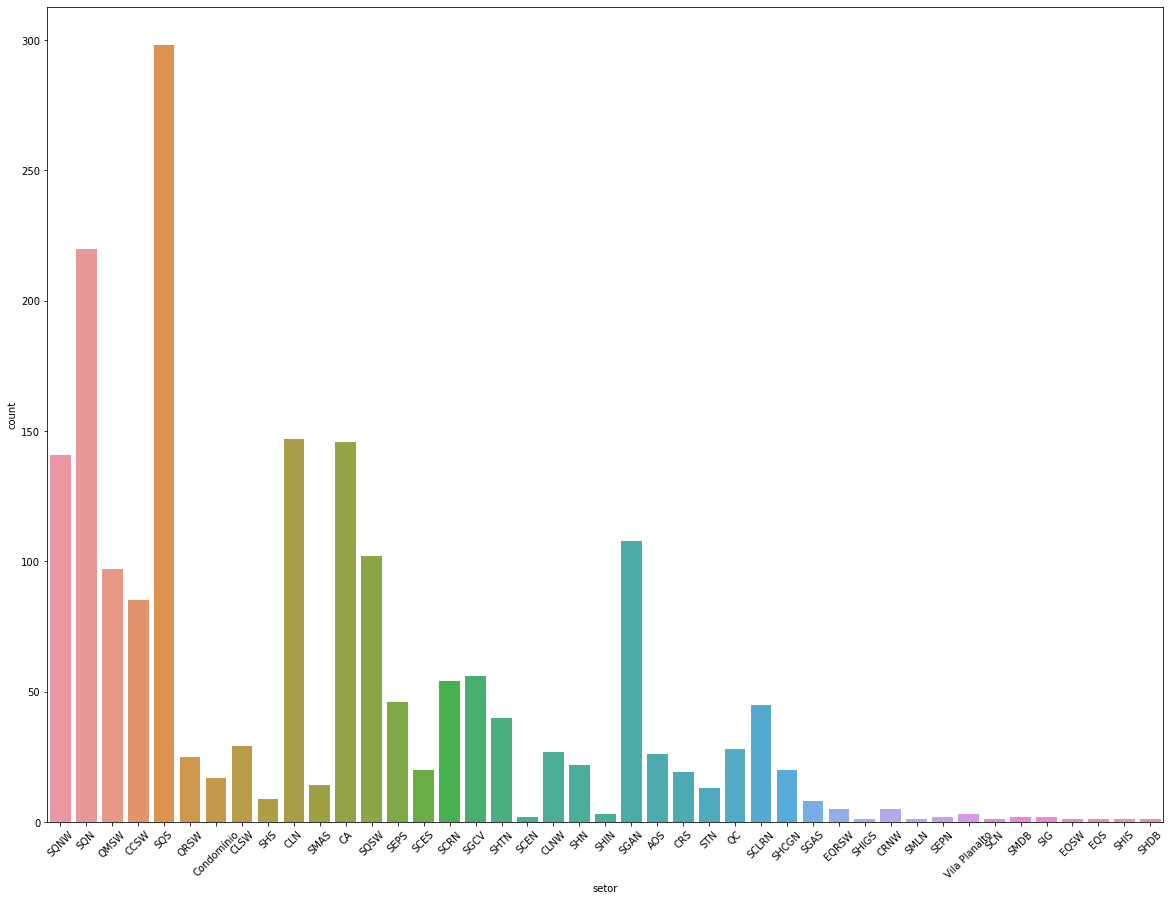

In [1342]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20,15))
plt.xticks(rotation = 45)
sns.countplot(data = df, x = 'setor')

In [1343]:
columns = ['Unnamed: 0','valueperm2','Posição do Sol','Posição do Imóvel','Andar do Apartamento','Total de Andar do Empreendimento',
'Nome do Edifício','Área Total','Aceita Financiamento','Área Terreno','Unidades no Andar','Aceita Permuta']
df.drop(columns=columns,inplace=True)

In [1344]:
df.loc[df['IPTU R$'] < 3,'IPTU R$'] = df['IPTU R$']*1000
df.loc[df['Condomínio R$'] < 3,'Condomínio R$'] = df['Condomínio R$']*1000

In [1345]:
pd.set_option('display.max_colwidth', None)

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor
6,QRSW 2 Bloco B 14,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-sudoeste-brasilia-df-qrsw-2-bloco-b-14-70149,2450,56,2.0,NaN,NaN,440.0,BRASÍLIA - SUDOESTE,96.000,QRSW
10,CLSW 300B Bloco 3 Leonardo Center,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-sudoeste-brasilia-df-clsw-300b-bloco-3-506720,2000,30,1.0,NaN,1.0,388.0,BRASÍLIA - SUDOESTE,88.000,CLSW
11,SQNW 103 Bloco B,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-noroeste-brasilia-df-sqnw-103-bloco-b-594625,4650,76,2.0,1.0,2.0,838.0,BRASÍLIA - NOROESTE,201.000,SQNW
15,SQS 210 Bloco G,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-sul-brasilia-df-sqs-210-bloco-g-595950,4000,104,3.0,1.0,1.0,1100.0,BRASÍLIA - ASA SUL,188.000,SQS
16,CLN 207 Bloco C,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-asa-norte-brasilia-df-cln-207-bloco-c-597336,599,31,1.0,NaN,NaN,199.0,BRASÍLIA - ASA NORTE,320.000,CLN
23,CA 02,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-lago-norte-brasilia-df-ca-02-530586,680,28,1.0,NaN,NaN,305.0,BRASÍLIA - LAGO NORTE,170.000,CA
25,CCSW 2 Lote 3,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-sudoeste-brasilia-df-ccsw-2-lote-3-57437,4100,68,2.0,1.0,1.0,1222.0,BRASÍLIA - SUDOESTE,403.000,CCSW
28,SEPS 712/912,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-asa-sul-brasilia-df-seps-712-912-594165,1300,24,1.0,NaN,NaN,291.0,BRASÍLIA - ASA SUL,52.000,SEPS
29,SQN 310 Bloco I,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-norte-brasilia-df-sqn-310-bloco-i-268101,4850,180,3.0,1.0,1.0,814.0,BRASÍLIA - ASA NORTE,166.000,SQN
30,SQS 212 Bloco J,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-asa-sul-brasilia-df-sqs-212-bloco-j-532953,14500,245,4.0,4.0,3.0,2290.0,BRASÍLIA - ASA SUL,3.940,SQS


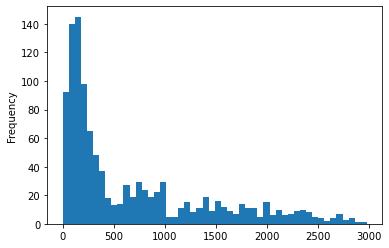

In [1346]:
df['IPTU R$'].plot(kind='hist', bins = 50)
df.loc[df['IPTU R$'] <1000].head(50) #da pra ver que os iptus mensais puxam uma cauda pra esquerda na distribuição

In [1347]:
df['iptuvsarea'] = df['IPTU R$']/df.area #criar o indicador pra verificar possíveis descrepancias nos iptus que vem o total/o mensal

In [1348]:
df.loc[df['iptuvsarea'] < 10] #quando cortamos os menores que 10 parece claramente ser o caso dos pagamentos de iptu mensal

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea
6,QRSW 2 Bloco B 14,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-sudoeste-brasilia-df-qrsw-2-bloco-b-14-70149,2450,56,2.0,NaN,NaN,440.0,BRASÍLIA - SUDOESTE,96.0,QRSW,1.714286
10,CLSW 300B Bloco 3 Leonardo Center,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-sudoeste-brasilia-df-clsw-300b-bloco-3-506720,2000,30,1.0,NaN,1.0,388.0,BRASÍLIA - SUDOESTE,88.0,CLSW,2.933333
11,SQNW 103 Bloco B,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-noroeste-brasilia-df-sqnw-103-bloco-b-594625,4650,76,2.0,1.0,2.0,838.0,BRASÍLIA - NOROESTE,201.0,SQNW,2.644737
15,SQS 210 Bloco G,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-sul-brasilia-df-sqs-210-bloco-g-595950,4000,104,3.0,1.0,1.0,1100.0,BRASÍLIA - ASA SUL,188.0,SQS,1.807692
23,CA 02,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-lago-norte-brasilia-df-ca-02-530586,680,28,1.0,NaN,NaN,305.0,BRASÍLIA - LAGO NORTE,170.0,CA,6.071429
...,...,...,...,...,...,...,...,...,...,...,...,...
1882,QRSW 8 Bloco A 10,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-sudoeste-brasilia-df-qrsw-8-bloco-a-10-493219,2200,62,2.0,NaN,NaN,570.0,BRASÍLIA - SUDOESTE,198.0,QRSW,3.193548
1886,CA 11,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-lago-norte-brasilia-df-ca-11-184564,2800,64,1.0,1.0,1.0,740.0,BRASÍLIA - LAGO NORTE,70.0,CA,1.093750
1890,SQN 304 Bloco D,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-norte-brasilia-df-sqn-304-bloco-d-597445,3900,200,3.0,1.0,NaN,NaN,BRASÍLIA - ASA NORTE,310.0,SQN,1.550000
1891,CLN 405 Bloco D,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-asa-norte-brasilia-df-cln-405-bloco-d-597494,749,28,1.0,NaN,NaN,379.0,BRASÍLIA - ASA NORTE,141.0,CLN,5.035714


In [1349]:
df.setor.unique()

array(['SQNW', 'SQN', 'QMSW', 'CCSW', 'SQS', 'QRSW', 'Condomínio', 'CLSW',
       'SHS', 'CLN', 'SMAS', 'CA', 'SQSW', 'SEPS', 'SCES', 'SCRN', 'SGCV',
       'SHTN', 'SCEN', 'CLNW', 'SHN', 'SHIN', 'SGAN', 'AOS', 'CRS', 'STN',
       'QC', 'SCLRN', 'SHCGN', 'SGAS', 'EQRSW', 'SHIGS', 'CRNW', 'SMLN',
       'SEPN', 'Vila Planalto', 'SCN', 'SMDB', 'SIG', 'EQSW', 'EQS',
       'SHIS', 'SHDB'], dtype=object)

In [1350]:
setores = ['SQNW', 'SQN', 'QMSW', 'CCSW', 'SQS', 'QRSW', 'Condomínio', 'CLSW',
       'SHS', 'CLN', 'SMAS', 'CA', 'SQSW', 'SEPS', 'SCES', 'SCRN', 'SGCV',
       'SHTN', 'SCEN', 'CLNW', 'SHN', 'SHIN', 'SGAN', 'AOS', 'CRS', 'STN',
       'QC', 'SCLRN', 'SHCGN', 'SGAS', 'EQRSW', 'SHIGS', 'CRNW', 'SMLN',
       'SEPN', 'Vila Planalto', 'SCN', 'SMDB', 'SIG', 'EQSW', 'EQS',
       'SHIS', 'SHDB']
setores.sort()
print(setores)

['AOS', 'CA', 'CCSW', 'CLN', 'CLNW', 'CLSW', 'CRNW', 'CRS', 'Condomínio', 'EQRSW', 'EQS', 'EQSW', 'QC', 'QMSW', 'QRSW', 'SCEN', 'SCES', 'SCLRN', 'SCN', 'SCRN', 'SEPN', 'SEPS', 'SGAN', 'SGAS', 'SGCV', 'SHCGN', 'SHDB', 'SHIGS', 'SHIN', 'SHIS', 'SHN', 'SHS', 'SHTN', 'SIG', 'SMAS', 'SMDB', 'SMLN', 'SQN', 'SQNW', 'SQS', 'SQSW', 'STN', 'Vila Planalto']


In [1351]:
df.loc[df['iptuvsarea'] < 0.1].head(50) #nesses casos o iptu ainda não tá multiplicando por mil então vamos ajustar
df.loc[df['iptuvsarea'] < 0.1,'IPTU R$'] = df['IPTU R$'] * 1000

In [1352]:
df.loc[df['iptuvsarea'] < 0.1].head(50) 

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea
30,SQS 212 Bloco J,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-asa-sul-brasilia-df-sqs-212-bloco-j-532953,14500,245,4.0,4.0,3.0,2290.0,BRASÍLIA - ASA SUL,3940.0,SQS,0.016082
36,SQNW 309 Bloco I Residencial Riviera,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-noroeste-brasilia-df-sqnw-309-bloco-i-591463,5000,101,3.0,1.0,1.0,9.0,BRASÍLIA - NOROESTE,0.0,SQNW,0.000000
116,SQN 303 Bloco E,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-asa-norte-brasilia-df-sqn-303-bloco-e-470731,13000,240,4.0,4.0,NaN,1700.0,BRASÍLIA - ASA NORTE,4409.0,SQN,0.018371
121,SQNW 109,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-noroeste-brasilia-df-sqnw-109-553002,10900,148,4.0,2.0,4.0,1648.0,BRASÍLIA - NOROESTE,4219.0,SQNW,0.028507
205,SQS 302 Bloco E,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-asa-sul-brasilia-df-sqs-302-bloco-e-324510,5500,164,4.0,1.0,1.0,1120.0,BRASÍLIA - ASA SUL,3031.0,SQS,0.018482
239,QC 2,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-2-591930,1400,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
301,QC 6,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-6-589269,1500,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
353,SQS 211 Bloco I,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-asa-sul-brasilia-df-sqs-211-bloco-i-579804,45000,900,4.0,4.0,3.0,6.0,BRASÍLIA - ASA SUL,12000.0,SQS,0.013333
373,SQNW 103 Bloco C,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-noroeste-brasilia-df-sqnw-103-bloco-c-568420,15000,260,4.0,4.0,4.0,2200.0,BRASÍLIA - NOROESTE,5800.0,SQNW,0.022308
384,SQS 114 Bloco E,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-asa-sul-brasilia-df-sqs-114-bloco-e-525167,4000,114,2.0,NaN,1.0,1400.0,BRASÍLIA - ASA SUL,3041.0,SQS,0.026675


In [1353]:
df.loc[df['Condomínio R$'] < 50].head(50) #pensar em alguma forma de tratar esses condomínios, alguns tem que multiplicar por 100 e outros por 1000 claramente 

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea
36,SQNW 309 Bloco I Residencial Riviera,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-noroeste-brasilia-df-sqnw-309-bloco-i-591463,5000,101,3.0,1.0,1.0,9.00,BRASÍLIA - NOROESTE,0.0,SQNW,0.000000
239,QC 2,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-2-591930,1400,48,2.0,NaN,1.0,0.00,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
276,SQSW 101 Bloco C - Portinari,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-sudoeste-brasilia-df-sqsw-101-bloco-c-453283,15000,378,4.0,4.0,4.0,4.00,BRASÍLIA - SUDOESTE,NaN,SQSW,NaN
301,QC 6,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-6-589269,1500,48,2.0,NaN,1.0,0.00,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
353,SQS 211 Bloco I,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-asa-sul-brasilia-df-sqs-211-bloco-i-579804,45000,900,4.0,4.0,3.0,6.00,BRASÍLIA - ASA SUL,12000.0,SQS,0.013333
379,SQSW 305 Bloco D,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-sudoeste-brasilia-df-sqsw-305-bloco-d-394683,15000,260,4.0,4.0,3.0,3.50,BRASÍLIA - SUDOESTE,NaN,SQSW,NaN
408,SQSW 301,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-sudoeste-brasilia-df-sqsw-301-502228,11500,289,5.0,5.0,3.0,3.87,BRASÍLIA - SUDOESTE,NaN,SQSW,NaN
520,QMSW 2,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-sudoeste-brasilia-df-qmsw-2-234958,700,28,1.0,1.0,NaN,0.00,BRASÍLIA - SUDOESTE,NaN,QMSW,NaN
682,SQSW 101,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-sudoeste-brasilia-df-sqsw-101-434480,17000,147,4.0,4.0,4.0,3.40,BRASÍLIA - SUDOESTE,710.0,SQSW,4.829932
763,QC 10,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-10-592820,1700,48,2.0,NaN,1.0,0.00,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000


In [1354]:
df.loc[(df['Condomínio R$'] < 50) & (df['area'] > 120),'Condomínio R$'] = df['Condomínio R$'] * 1000

In [1355]:
df.loc[df['Condomínio R$'] < 50].head(50)

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea
36,SQNW 309 Bloco I Residencial Riviera,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-noroeste-brasilia-df-sqnw-309-bloco-i-591463,5000,101,3.0,1.0,1.0,9.0,BRASÍLIA - NOROESTE,0.0,SQNW,0.000000
239,QC 2,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-2-591930,1400,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
301,QC 6,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-6-589269,1500,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
520,QMSW 2,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-sudoeste-brasilia-df-qmsw-2-234958,700,28,1.0,1.0,NaN,0.0,BRASÍLIA - SUDOESTE,NaN,QMSW,NaN
763,QC 10,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-10-592820,1700,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
768,SQNW 109 Bloco K Andar alto,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-noroeste-brasilia-df-sqnw-109-bloco-k-518905,8000,163,4.0,4.0,3.0,0.0,BRASÍLIA - NOROESTE,1000.0,SQNW,6.134969
845,QC 11,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-11-596497,1700,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
1224,QMSW 4,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-sudoeste-brasilia-df-qmsw-4-581862,1500,30,1.0,NaN,1.0,4.0,BRASÍLIA - SUDOESTE,115.0,QMSW,3.833333
1305,SCLRN 705,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-asa-norte-brasilia-df-sclrn-705-215207,650,21,1.0,NaN,NaN,30.0,BRASÍLIA - ASA NORTE,NaN,SCLRN,NaN
1523,QC 8,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-8-567257,1600,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000


In [1356]:
df.loc[(df['Condomínio R$'] < 50),'Condomínio R$'] = df['Condomínio R$'] * 100

In [1357]:
df.loc[df['Condomínio R$'] < 50].head(50) #agora sim, ficaram só os condominios zerados que vamos resolver depois

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea
239,QC 2,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-2-591930,1400,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
301,QC 6,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-6-589269,1500,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
520,QMSW 2,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-sudoeste-brasilia-df-qmsw-2-234958,700,28,1.0,1.0,NaN,0.0,BRASÍLIA - SUDOESTE,NaN,QMSW,NaN
763,QC 10,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-10-592820,1700,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
768,SQNW 109 Bloco K Andar alto,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-noroeste-brasilia-df-sqnw-109-bloco-k-518905,8000,163,4.0,4.0,3.0,0.0,BRASÍLIA - NOROESTE,1000.0,SQNW,6.134969
845,QC 11,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-11-596497,1700,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
1523,QC 8,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-8-567257,1600,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000
1659,SHCGN 705 Bloco F,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-asa-norte-brasilia-df-shcgn-705-bloco-f-164007,1000,23,1.0,NaN,NaN,0.0,BRASÍLIA - ASA NORTE,58.0,SHCGN,2.521739
1854,QC 5,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-jardins-mangueiral-brasilia-df-qc-5-567255,1500,48,2.0,NaN,1.0,0.0,BRASÍLIA - JARDINS MANGUEIRAL,0.0,QC,0.000000


In [1358]:
df['iptuvsarea'] = df['IPTU R$']/df.area

In [1359]:
df.loc[df['iptuvsarea'] < 10,'IPTU R$'] = df['IPTU R$'] * 6 #nas mensais temos que multiplicar o valor por 6 já que são 6 parcelas

In [1360]:
df.loc[df['iptuvsarea'] < 10].head(50) #agora sim parece em linha e conseguimos até ajustar a distribuição

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea
6,QRSW 2 Bloco B 14,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-sudoeste-brasilia-df-qrsw-2-bloco-b-14-70149,2450,56,2.0,NaN,NaN,440.0,BRASÍLIA - SUDOESTE,576.0,QRSW,1.714286
10,CLSW 300B Bloco 3 Leonardo Center,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-sudoeste-brasilia-df-clsw-300b-bloco-3-506720,2000,30,1.0,NaN,1.0,388.0,BRASÍLIA - SUDOESTE,528.0,CLSW,2.933333
11,SQNW 103 Bloco B,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-noroeste-brasilia-df-sqnw-103-bloco-b-594625,4650,76,2.0,1.0,2.0,838.0,BRASÍLIA - NOROESTE,1206.0,SQNW,2.644737
15,SQS 210 Bloco G,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-sul-brasilia-df-sqs-210-bloco-g-595950,4000,104,3.0,1.0,1.0,1100.0,BRASÍLIA - ASA SUL,1128.0,SQS,1.807692
23,CA 02,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-lago-norte-brasilia-df-ca-02-530586,680,28,1.0,NaN,NaN,305.0,BRASÍLIA - LAGO NORTE,1020.0,CA,6.071429
25,CCSW 2 Lote 3,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-sudoeste-brasilia-df-ccsw-2-lote-3-57437,4100,68,2.0,1.0,1.0,1222.0,BRASÍLIA - SUDOESTE,2418.0,CCSW,5.926471
28,SEPS 712/912,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-asa-sul-brasilia-df-seps-712-912-594165,1300,24,1.0,NaN,NaN,291.0,BRASÍLIA - ASA SUL,312.0,SEPS,2.166667
29,SQN 310 Bloco I,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-norte-brasilia-df-sqn-310-bloco-i-268101,4850,180,3.0,1.0,1.0,814.0,BRASÍLIA - ASA NORTE,996.0,SQN,0.922222
34,SQS 410 Bloco T OTIMO AP COM AMBIENTES AMPLOS E QUARTO DEPOSITO,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-sul-brasilia-df-sqs-410-bloco-t-472649,2800,114,3.0,1.0,NaN,572.0,BRASÍLIA - ASA SUL,1542.0,SQS,2.254386
35,SQS 112 Bloco E,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-sul-brasilia-df-sqs-112-bloco-e-201930,3900,110,3.0,NaN,NaN,889.0,BRASÍLIA - ASA SUL,1134.0,SQS,1.718182


<AxesSubplot:ylabel='Frequency'>

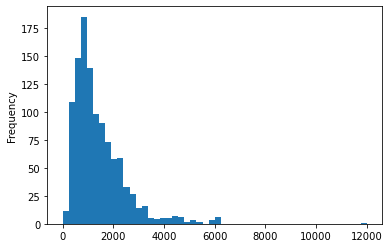

In [1361]:
df['IPTU R$'].plot(kind='hist', bins = 50) #a distribuição faz mais sentido também, agora parece com a real

### 3) Preenchendo os valores missing

In [1362]:
import numpy as np
cols = ["IPTU R$",'Condomínio R$']
df[cols] = df[cols].replace({'0':np.nan, 0:np.nan})

In [1363]:
(df['Condomínio R$'].isnull().sum(),df['IPTU R$'].isnull().sum())

(219, 792)

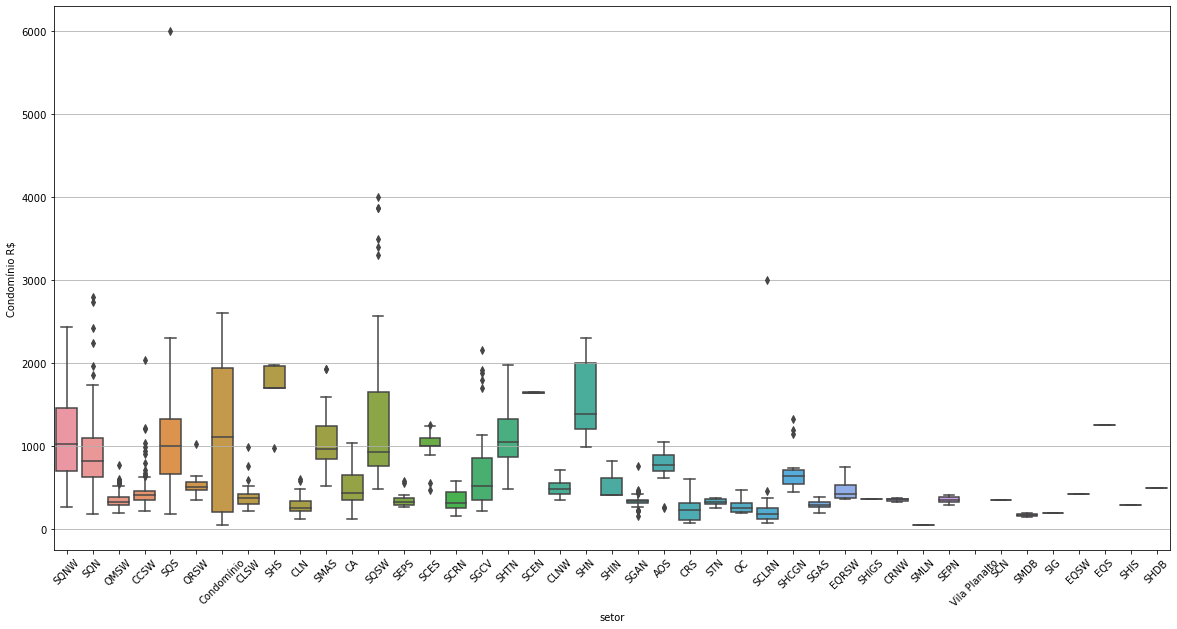

In [1364]:
plt.subplots(figsize = (20,10))
plt.grid()
plt.xticks(rotation = 45)
sns.boxplot(data = df, x = 'setor', y = 'Condomínio R$' ); #parece que faz sentido e realmente há muita variação entre os setores, podemos preencher com a mediana mas ainda vamos melhorar preenchendo pelo setor+band de area

In [1365]:
bins = [ 0,40,70,100,150,200]
df['areaband'] = np.searchsorted(bins, df['area'].values)

In [1366]:
df['setorareaband'] = df['setor'].astype(str) + '-' + df['areaband'].astype(str)

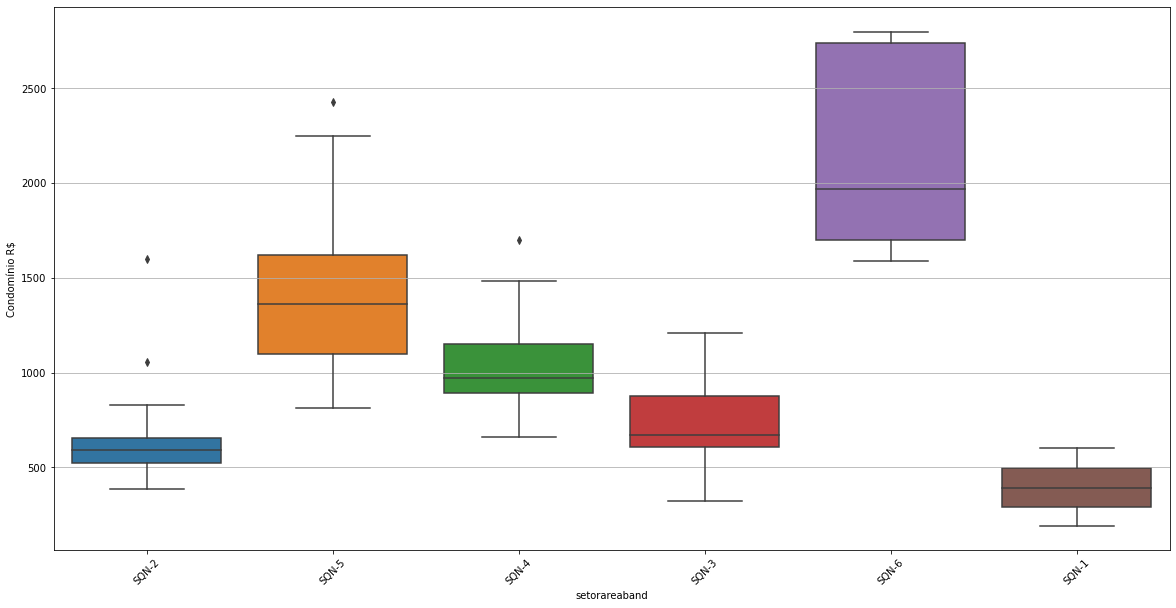

In [1367]:
df_norte = df.loc[df['setor'] == 'SQN']
plt.subplots(figsize = (20,10))
plt.grid()
plt.xticks(rotation = 45)
sns.boxplot(data = df_norte, x = 'setorareaband', y = 'Condomínio R$' ); #é gritante a variação do condomínio perante as bands na asa norte

In [1368]:
df['Condomínio R$'] = df['Condomínio R$'].fillna(df.groupby('setorareaband')['Condomínio R$'].transform('mean'))

In [1369]:
df['Condomínio R$'].isnull().sum()

16

In [1370]:
df['Condomínio R$'] = df['Condomínio R$'].fillna(df.groupby('areaband')['Condomínio R$'].transform('mean')) #para os que não tem média no areaband vamos usar a media da band de area

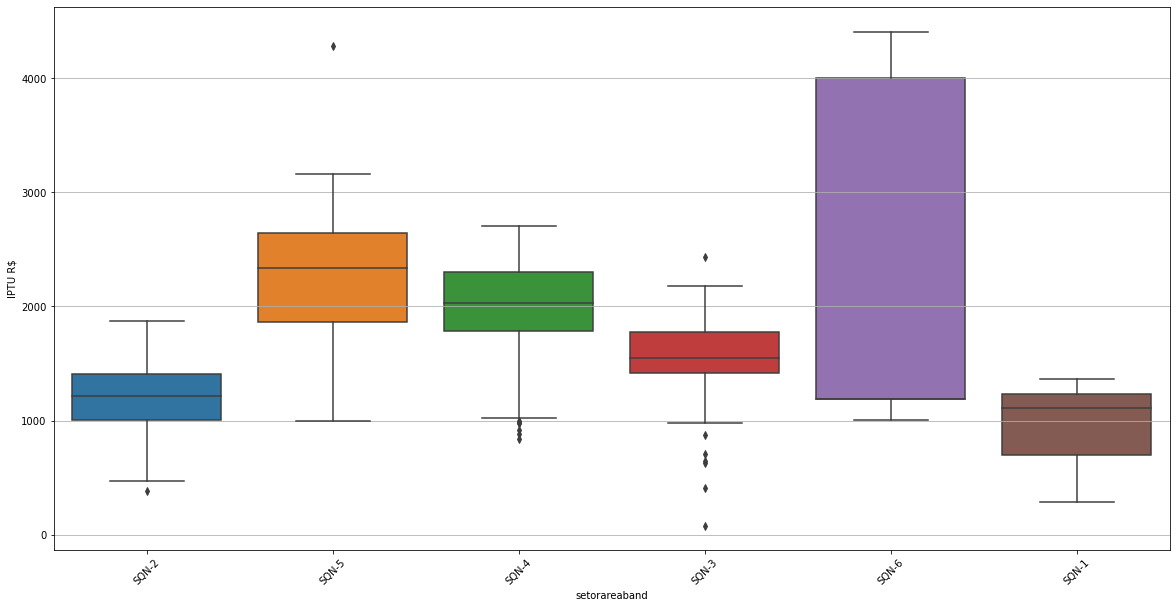

In [1371]:
df_norte = df.loc[df['setor'] == 'SQN']
plt.subplots(figsize = (20,10))
plt.grid()
plt.xticks(rotation = 45)
sns.boxplot(data = df_norte, x = 'setorareaband', y = 'IPTU R$' ); #visualizando só a asa norte pra ter uma dimensão da variação entre as bands do valor do iptu também

In [1372]:
df['IPTU R$'] = df['IPTU R$'].fillna(df.groupby('setorareaband')['IPTU R$'].transform('mean'))

In [1373]:
df[df['IPTU R$'].isnull()]

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea,areaband,setorareaband
33,SCES Trecho 4 Apartamento maravilhoso! - Condominio Brisas do Lago,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-asa-sul-brasilia-df-sces-trecho-4-383579,2700,40,1.0,1.0,1.0,1100.000000,BRASÍLIA - ASA SUL,NaN,SCES,NaN,1,SCES-1
55,SMAS,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-park-sul-brasilia-df-smas-523793,15000,211,3.0,3.0,4.0,1931.000000,BRASÍLIA - PARK SUL,NaN,SMAS,NaN,6,SMAS-6
79,SQSW 100 Bloco D Ed. Unicaflex ao lado do bar primeiro,https://www.dfimoveis.com.br/imovel/kitnet-1-quarto-aluguel-sudoeste-brasilia-df-sqsw-100-bloco-d-569333,1800,25,1.0,1.0,1.0,368.566866,BRASÍLIA - SUDOESTE,NaN,SQSW,NaN,1,SQSW-1
137,SMAS Trecho 1 C,https://www.dfimoveis.com.br/imovel/apartamento-4-quartos-aluguel-park-sul-brasilia-df-smas-trecho-1-c-430221,15000,211,4.0,3.0,4.0,1931.000000,BRASÍLIA - PARK SUL,NaN,SMAS,NaN,6,SMAS-6
383,Condomínio Jardim Botânico VI,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-jardim-botanico-brasilia-df-condominio-jardim-botanico-vi-513565,1450,36,1.0,1.0,NaN,130.000000,BRASÍLIA - JARDIM BOTANICO,NaN,Condomínio,NaN,1,Condomínio-1
570,SMLN MI Trecho 07,https://www.dfimoveis.com.br/imovel/apartamento-2-quartos-aluguel-lago-norte-brasilia-df-smln-mi-trecho-07-588040,2500,80,2.0,NaN,NaN,50.000000,BRASÍLIA - LAGO NORTE,NaN,SMLN,NaN,3,SMLN-3
640,SCES Trecho 4,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-asa-sul-brasilia-df-sces-trecho-4-228694,4200,40,1.0,1.0,NaN,829.000000,BRASÍLIA - ASA SUL,NaN,SCES,NaN,1,SCES-1
645,SEPS 713/913,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-asa-sul-brasilia-df-seps-713-913-387902,1200,43,1.0,NaN,NaN,400.000000,BRASÍLIA - ASA SUL,NaN,SEPS,NaN,2,SEPS-2
667,SCRN 702/703 Bloco C,https://www.dfimoveis.com.br/imovel/apartamento-3-quartos-aluguel-asa-norte-brasilia-df-scrn-702-703-bloco-c-568153,5000,110,3.0,2.0,1.0,500.000000,BRASÍLIA - ASA NORTE,NaN,SCRN,NaN,4,SCRN-4
759,SCES Trecho 4,https://www.dfimoveis.com.br/imovel/apartamento-1-quarto-aluguel-asa-sul-brasilia-df-sces-trecho-4-592217,3850,40,1.0,1.0,1.0,558.000000,BRASÍLIA - ASA SUL,NaN,SCES,NaN,1,SCES-1


In [1374]:
df['IPTU R$'] = df['IPTU R$'].fillna(df.groupby('areaband')['IPTU R$'].transform('mean')) #para os que não tem média no areaband vamos usar a media da band de area

In [1375]:
df[df['Quartos'].isnull()]

,name,link,price,area,Quartos,Suítes,Garagens,Condomínio R$,Cidade,IPTU R$,setor,iptuvsarea,areaband,setorareaband
713,SCLRN 707 Bloco C,https://www.dfimoveis.com.br/imovel/kitnet-0-quartos-aluguel-asa-norte-brasilia-df-sclrn-707-bloco-c-290156,950,33,NaN,NaN,NaN,100.0,BRASÍLIA - ASA NORTE,819.3125,SCLRN,NaN,1,SCLRN-1


In [1376]:
df['Quartos'] = df['Quartos'].fillna(df.groupby('setorareaband')['Quartos'].transform('median'))

### 4)Preparação final do dataset pra regressão

In [1377]:
df['iptuvsarea'] = df['IPTU R$']/df.area
df['condovsarea'] = df['Condomínio R$']/df.area
#df['areaporquarto'] = df['area']/df.Quartos

In [1378]:
df['price'] = df['price'] + df['Condomínio R$'] + df['IPTU R$']/12

In [1379]:
cols = ['Cidade','Suítes','Garagens','link','name','Condomínio R$','IPTU R$','setorareaband']
df.drop(columns=cols,inplace=True)

In [1380]:
df = df.reset_index(drop=True)

In [1382]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df['setor'].to_numpy().reshape(-1,1))


OneHotEncoder(handle_unknown='ignore')

In [1383]:
import pickle
with open('../model/ohe.pkl', 'wb') as f:
    pickle.dump(ohe, f)

In [1384]:
with open('../model/ohe.pkl', 'rb') as f:
    ohe = pickle.load(f)

In [1385]:
dummies = ohe.transform(df['setor'].to_numpy().reshape(-1,1))

In [1386]:
dummies = pd.DataFrame(dummies.toarray(), columns = ohe.get_feature_names())

c:\Users\bruno\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [1388]:
df = pd.concat([df,dummies],axis=1)

,price,area,Quartos,setor,iptuvsarea,areaband,condovsarea,x0_AOS,x0_CA,x0_CCSW,...,x0_SIG,x0_SMAS,x0_SMDB,x0_SMLN,x0_SQN,x0_SQNW,x0_SQS,x0_SQSW,x0_STN,x0_Vila Planalto
0,10891.666667,150,3.0,SQNW,15.333333,4,11.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2727.935185,60,2.0,SQN,19.587037,2,8.833333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1671.561404,26,1.0,QMSW,28.874494,1,11.884615,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4079.916667,26,1.0,CCSW,32.730769,1,15.730769,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3912.583333,92,3.0,SQS,17.945652,3,5.706522,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888,1739.947917,45,1.0,SCRN,22.119444,2,7.933333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1889,3593.916667,89,3.0,SQS,15.898876,3,7.595506,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1890,1579.083333,43,1.0,CLN,15.651163,2,5.186047,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,8124.330952,100,2.0,SQS,14.919714,3,10.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [1389]:
from sklearn.model_selection import train_test_split
x = df.drop(columns = ['price','setor'])
Y = df.price
X_train, X_test, y_train, y_test = train_test_split(x, Y , test_size= 0.3,random_state=42)

#### 5) Escolhendo o modelo

In [1390]:
import statsmodels.api as sm
X = X_train['area']
y = y_train
X = sm.add_constant(X)
olsmod = sm.OLS(y,X)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     5080.
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:15:19   Log-Likelihood:                -11548.
No. Observations:                1325   AIC:                         2.310e+04
Df Residuals:                    1323   BIC:                         2.311e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.0199     67.660      2.572      0.0

c:\Users\bruno\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [1391]:
X_pred = X_test['area'].to_numpy()
X_pred = sm.add_constant(X_pred)
y_pred = olsres.predict(X_pred)
baseline_errors = abs(y_pred - y_test)
baseline_errors = pd.DataFrame(baseline_errors)
print(f'Erro médio da nossa regressão baseline (Em reais): {round(np.mean(baseline_errors),2)}');

Erro médio da nossa regressão baseline (Em reais): price    1094.69
dtype: float64


c:\Users\bruno\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [1392]:
def plotComparacao(y_test,y_pred,nomedaregressao):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)   
    plt.scatter(range(len(y_test)), y_test, color = 'blue')
    plt.scatter(range(len(y_pred)), y_pred, color = 'red')
    plt.title(nomedaregressao, fontsize = 18)
    plt.xlabel('Nº da previsão')
    plt.ylabel('Custo de Moradia (Aluguel + Condominio + IPTU diluído)')
    fig.legend(labels = ('Real','Previsões'),loc='upper left', fontsize = 16)
    plt.show()
    return

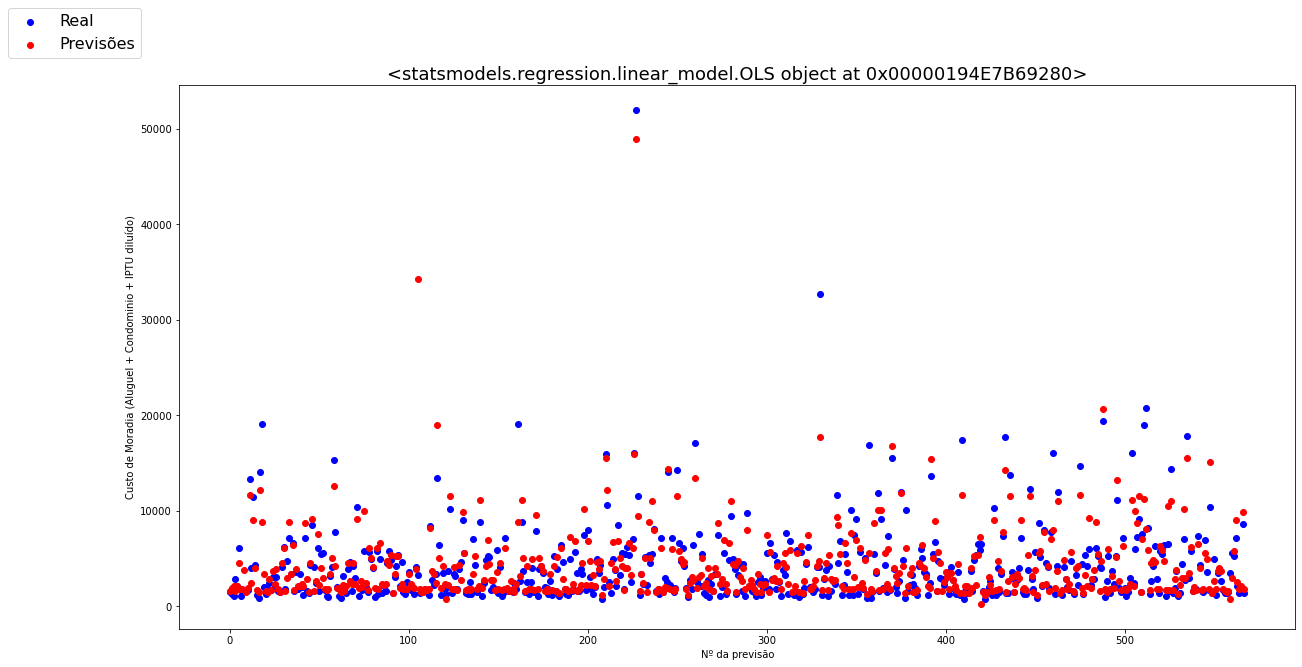

In [1393]:
plotComparacao(y_test,y_pred,olsmod)

In [1394]:
import statsmodels.api as sm
X = X_train
y = y_train
X = sm.add_constant(X)
olsmod = sm.OLS(y,X)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     202.1
Date:                Fri, 05 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:15:20   Log-Likelihood:                -11247.
No. Observations:                1325   AIC:                         2.258e+04
Df Residuals:                    1282   BIC:                         2.280e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -760.1918    163.274  

c:\Users\bruno\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [1395]:
X_pred = X_test.to_numpy()
X_pred = sm.add_constant(X_pred)
y_pred = olsres.predict(X_pred)
baseline_errors = abs(y_pred - y_test)
baseline_errors = pd.DataFrame(baseline_errors)
print(f'Erro médio da nossa regressão múltipla (Em reais): {round(np.mean(baseline_errors),2)}');

Erro médio da nossa regressão múltipla (Em reais): price    997.33
dtype: float64


c:\Users\bruno\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3417: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


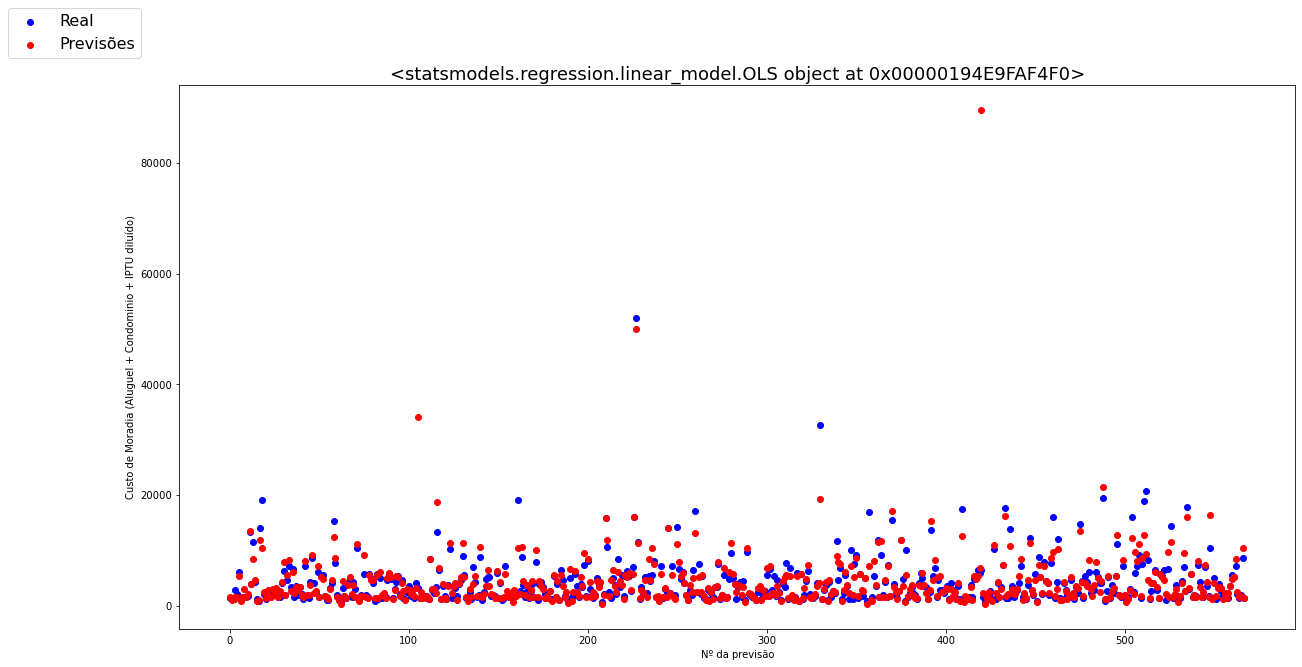

In [1396]:
plotComparacao(y_test,y_pred,olsmod)

In [1397]:
y_train

358     3993.416667
1049    1411.000000
236     1829.000000
551     3180.625000
1767    7476.000000
           ...     
1130    4942.983974
1294    4714.163043
860     1755.000000
1459    1807.645833
1126    2949.000000
Name: price, Length: 1325, dtype: float64

In [1398]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10, random_state=42)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
erro = abs(y_pred - y_test)
print(f'Erro médio da nossa primeira regressão random forest é (Em reais): {round(np.mean(erro),2)}');

Erro médio da nossa primeira regressão random forest é (Em reais): 811.4


In [1399]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=50, max_depth=20,min_samples_split=3, random_state=42)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
erro = abs(y_pred - y_test)
print(f'Erro médio da nossa segunda regressão random forest é (Em reais): {round(np.mean(erro),2)}');

Erro médio da nossa segunda regressão random forest é (Em reais): 802.84


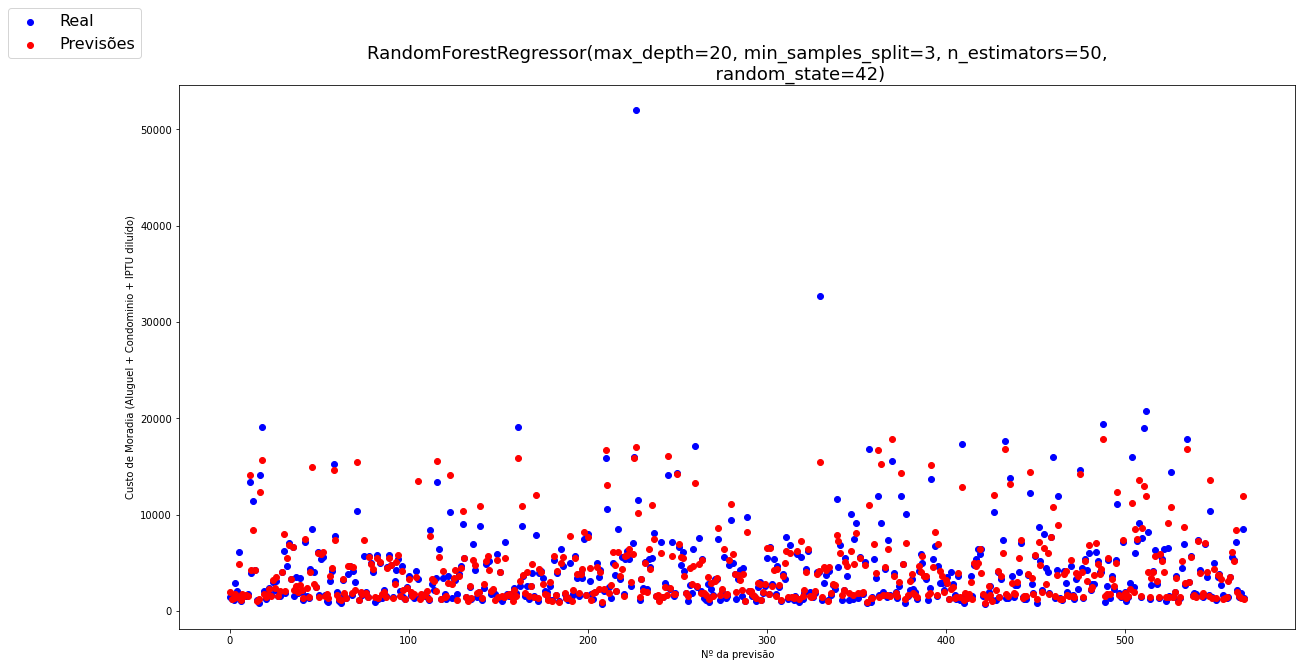

In [1400]:
plotComparacao(y_test,y_pred,regressor)

Portanto, este vai ser o nosso modelo final.